Supporting script for:

**How to make climate-neutral aviation fly** \
*Romain Sacchi, Viola Becattini, Paolo Gabrielli, Brian Cox, Alois Dirnaichner, Christian Bauer, and Marco Mazzotti*

Questions: romain.sacchi(at)psi.ch

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.linalg import toeplitz
import matplotlib.ticker as plticker
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings("ignore")
import itertools
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.offsetbox import AnchoredText

def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]

In [11]:
# load time series of CO2 and SLCF emissions
df = pd.read_excel("results from airplanes emissions fleet model.xlsx", skiprows=0) # <-- in kg/year

# we rename the columns for simplicity
df.columns = ['Tg/year', 'fuel', 'background', 'scenario', "km", 'HFC-152a', 'H',
               'HCFC-140', 'HCFC-22', 'CH4', 'HFC-134a', 'R-10',
               'HFC-125', 'CFC-11', 'HFC-143a', 'CFC-113',
               'CO2', 'CO2 (flight)', 'NOx',
               'BC', 'SOx', 'H2O', 'Cirrus',
               "LOP - infras.", "LOP - fuel supply", "LOP - compensation",
               "FWD - infras.", "FWD - fuel supply", "FWD - compensation",
               "electricity - infras.", "electricity - fuel supply", "electricity - LOP", "electricity - FWD", "electricity - compensation",
               "cost - infras-", "cost - fuel supply", "cost - kerosene", "cost - FT", "cost - H2", "cost - DAC", "cost - compensation"   
]
df = df.fillna(0)

In [12]:
start = 2018
end = 2100
alpha=.8

In [13]:
# returns linear operator to convert emissions to forcing
# from Lynch et al. 2021
def EFmod(nyr,a):
    Fcal = np.zeros((nyr)) # create linear operator to convert emissions to forcing
    time = np.arange(nyr+1)    # extend time array to compute derivatives
    F_0 = a[4]*a[13]*a[0]*time # compute constant term (if there is one, otherwise a[0]=0)
    for j in [1,2,3]:          # loop over gas decay terms to calculate AGWP using AR5 formula
        F_0=F_0+a[j]*a[4]*a[13]*a[j+5]*(1-np.exp(-time/a[j+5]))
    for i in range(0,nyr):     # first-difference AGWP to obtain AGFP
        Fcal[i]=F_0[i+1]-F_0[i]

    return toeplitz(Fcal, np.zeros_like(Fcal))

In [14]:
# Radiative forcing for SLCPs
# mW/m^2/Mt

RFI = {
    "low": {
        "HFC-152a":8.71e-12 * 1e9 * 1e3,
        "H": 3.64e-13 * 1e9 * 1e3,
        "HCFC-140": 2.75e-12 * 1e9 * 1e3,
        "HCFC-22": 1.4e-11 * 1e9 * 1e3,
        "CH4": 1.36e-13 * 1e9 * 1e3,
        "HFC-134a": 9.23e-12 * 1e9 * 1e3,
        "R-10": 6.09e-12 * 1e9 * 1e3,
        "HFC-125": 1.1e-11 * 1e9 * 1e3,
        "CFC-11": 1.06e-11 * 1e9 * 1e3,
        "HFC-143a": 1.13e-11 * 1e9 * 1e3,
        "CFC-113": 9.06e-12 * 1e9 * 1e3,
        "CO2": 1.70E-15 * 1e9 * 1e3,
        "NOx": -7.87 * (14/46), # RF coeff. for NOx
        "BC": 7.95, # RF coeff. for BC
        "SOx": -49.78, # RF coeff. for SO4
        "H2O": 0.0021, # RF coeff. for H2O
        "Cirrus": 6.3e-10# RF coeff. for Cirrus
    },
    "medium": {
        "HFC-152a": 8.71e-12 * 1e9 * 1e3,
        "H": 3.64e-13 * 1e9 * 1e3,
        "HCFC-140": 2.75e-12 * 1e9 * 1e3,
        "HCFC-22": 1.4e-11 * 1e9 * 1e3,
        "CH4": 1.36e-13 * 1e9 * 1e3,
        "HFC-134a": 9.23e-12 * 1e9 * 1e3,
        "R-10": 6.09e-12 * 1e9 * 1e3,
        "HFC-125": 1.1e-11 * 1e9 * 1e3,
        "CFC-11": 1.06e-11 * 1e9 * 1e3,
        "HFC-143a": 1.13e-11 * 1e9 * 1e3,
        "CFC-113": 9.06e-12 * 1e9 * 1e3,
        "CO2": 1.70E-15 * 1e9 * 1e3,
        "NOx": 5.5 *(14/46), # RF coeff. for NOx
        "BC": 100.67, # RF coeff. for BC
        "SOx": -19.91, # RF coeff. for SO4
        "H2O": 0.0052, # RF coeff. for H2O
        "Cirrus": 9.36e-10 # RF coeff. for Cirrus
    },
    "high": {
        "HFC-152a":8.71e-12 * 1e9 * 1e3,
        "H": 3.64e-13 * 1e9 * 1e3,
        "HCFC-140": 2.75e-12 * 1e9 * 1e3,
        "HCFC-22": 1.4e-11 * 1e9 * 1e3,
        "CH4": 1.36e-13 * 1e9 * 1e3,
        "HFC-134a": 9.23e-12 * 1e9 * 1e3,
        "R-10": 6.09e-12 * 1e9 * 1e3,
        "HFC-125": 1.1e-11 * 1e9 * 1e3,
        "CFC-11": 1.06e-11 * 1e9 * 1e3,
        "HFC-143a": 1.13e-11 * 1e9 * 1e3,
        "CFC-113": 9.06e-12 * 1e9 * 1e3,
        "CO2": 1.70E-15 * 1e9 * 1e3,
        "NOx": 12.57 * (14/46), # RF coeff. for NOx
        "BC": 428.65, # RF coeff. for BC
        "SOx": -6.87, # RF coeff. for SO4
        "H2O": 0.0083, # RF coeff. for H2O
        "Cirrus": 1.39e-9 # RF coeff. for Cirrus
    }
}


# molecular mass for SLCPs
# kg/mol
mol_mass = {
    "HFC-152a":66.05 / 1e3,
    "H": 1.01 / 1e3,
    "HCFC-140": 133.4 / 1e3,
    "HCFC-22": 86.47 / 1e3,
    "CH4": 16.04 / 1e3,
    "HFC-134a": 102.03 / 1e3,
    "R-10": 153.823 / 1e3,
    "HFC-125": 120.02 / 1e3,
    "CFC-11": 137.37 / 1e3,
    "HFC-143a": 84.04 / 1e3,
    "CFC-113": 187.375 / 1e3,
    'NOx': 14/1e3,
    'BC': 12/1e3, 
    'SOx': 64/1e3, 
    'H2O': 18/1e3,
    "Cirrus": 0
}

# lifetimes for SLCPs
# years
RF_lifetime = {
    "HFC-152a":1.6,
    "H": 2.5,
    "HCFC-140": 5,
    "HCFC-22": 11.9,
    "CH4": 11.8,
    "HFC-134a": 14,
    "R-10": 32,
    "HFC-125": 30,
    "CFC-11": 52,
    "HFC-143a": 51,
    "CFC-113": 93,
    'NOx': 11.8,
    'BC': 0.02, 
    'SOx': 0.011, 
    'H2O': 0.8,
    "Cirrus": 0.00057
}

In [15]:
# first set up AR5 model parameters, using syntax of FaIRv1.3 but units of GtCO2, not GtC
ny2=len(range(start, end + 1))

m_atm=5.1352*10**18 # AR5 official mass of atmosphere in kg
m_air=28.97*10**-3  # AR5 official molar mass of air
m_co2=44.01*10**-3  # AR5 official molar mass of CO2

a_ar5=np.zeros(20)

# Set to AR5 Values for CO2
a_ar5[0:4] = [0.21787,0.22896,0.28454,0.26863]
a_ar5[4] = 1.e12*1.e6/m_co2/(m_atm/m_air)# old value = 0.471 ppm/GtC # convert GtCO2 to ppm
a_ar5[5:9] = [1.e8,381.330,34.7850,4.12370]
a_ar5[10:12] = [0.631*0.7,0.429*0.7] #AR5 sensitivity coeffs multiplied by 0.7 to give ECS of 2.75K
a_ar5[13] = 1.37e-2 # rad efficiency in W/m2/ppm
a_ar5[14] = 0
a_ar5[15:17] = [8.400,409.5]
a_ar5[18:21] = 0

FCO2 = EFmod(ny2,a_ar5)
FCO2_inv = np.linalg.inv(FCO2)

In [16]:
# load unitary emissions from DAC
dac = pd.read_excel("performances of DAC from 2050 until 2100.xlsx", skiprows=0)

# rename columns
dac.columns = [
   'background', 'year', 'HFC-152a', 'H', 'HCFC-140', 'HCFC-22', 'CH4', 'HFC-134a', 'R-10','HFC-125', 'CFC-11', 'HFC-143a', 'CFC-113', 'CO2',
   "flight - CO2", "flight - NOx", "flight - Black carbon", "flight - Sulfur oxides", "flight - Water vapour", "flight - Cirrus",
   "LOP - infras.", "LOP - fuel supply", "LOP - compensation",
   "FWD - infras.", "FWD - fuel supply", "FWD - compensation",
   "electricity - infras.", "electricity - fuel supply", "electricity - LOP", "electricity - FWD", "electricity - compensation",
   "cost - infras.", "cost - fuel supply", "cost - kerosene", "cost - FT", "cost - H2", "cost - DAC", "cost - compensation"          
]

dac = dac.fillna(0)

d_colors = {
    'HFC-152a':"green",
    'H':"orange",
    'HCFC-140':"red",
    'HCFC-22':"brown",
    'CH4':"grey",
    'HFC-134a':"magenta",
    'R-10':"cyan",
    'HFC-125':"olive",
    'CFC-11':"purple",
    'HFC-143a':"pink",
    'CFC-113':"black",
    'CO2': "royalblue"
}

d_map = {
    "surface - CO2": "CO2",
    "surface - Others": ['HFC-152a', 'H', 'HCFC-140', 'HCFC-22', 'CH4', 'HFC-134a', 'R-10', 'HFC-125', 'CFC-11', 'HFC-143a', 'CFC-113',],
    "flight - CO2": "CO2 (flight)",
    "flight - Cirrus": "Cirrus",
    "flight - NOx": "NOx",
    "flight - Others": ['BC', 'SOx', 'H2O']
}
d_map_rev = {
    "CO2": "surface - CO2",
    'HFC-152a': "surface - Others", 
    'H': "surface - Others", 
    'HCFC-140': "surface - Others", 
    'HCFC-22': "surface - Others", 
    'CH4': "surface - Others", 
    'HFC-134a': "surface - Others", 
    'R-10': "surface - Others", 
    'HFC-125': "surface - Others", 
    'CFC-11': "surface - Others", 
    'HFC-143a': "surface - Others", 
    'CFC-113': "surface - Others",
    "CO2 (flight)": "flight - CO2",
    "Cirrus": "flight - Cirrus",
    "NOx": "flight - NOx",
    'BC': "flight - Others", 
    'SOx': "flight - Others", 
    'H2O': "flight - Others"
}

alfa = 0.6

col_tuples = []
col_tuples2 = []
for a in ["flight CO2-neutral", "warming-neutral", "climate-neutral"]:
    for b in dac.columns[1:]:
        col_tuples.append((a, b))
    for c in d_map:
        col_tuples2.append((a, c))

case = "medium"

y = range(2018, 2101)
a = ["Business As Usual", "Paris Agreement"]
b = ["Growth", "Stationary", "Decline",]
c = ["jet fuel", "syn-jet fuel"]
d = ["low", "medium", "high"]
e = ["flight CO2-neutral", "warming-neutral", "climate-neutral"]
indices = np.array(list(itertools.product(a, b, c, d, e, y)))

col_tuples3 = ["background", "scenario", "fuel", "case", "mitigation"] + list(dac.columns)[20:] + ["storage - infras.", "storage - fuel supply", "storage - compensation"]
df_results = pd.DataFrame(0, index=np.arange(2018, 2101).tolist() * 36 * 3, columns=col_tuples3)
df_results.loc[:, ["background", "scenario", "fuel", "case", "mitigation"]] = indices[:, :-1]

title_labels = {
    ("Business As Usual", "Growth", "Amount"): "a)",
    ("Business As Usual", "Stationary", "Amount"): "b)",
    ("Business As Usual", "Decline", "Amount"): "c)",
    ("Business As Usual", "Growth", "RF"): "d)",
    ("Business As Usual", "Stationary", "RF"): "e)",
    ("Business As Usual", "Decline", "RF"): "f)",
    ("Business As Usual", "Growth", "CDR"): "g)",
    ("Business As Usual", "Stationary", "CDR"): "h)",
    ("Business As Usual", "Decline", "CDR"): "i)",
    ("Paris Agreement", "Growth", "Amount"): "a)",
    ("Paris Agreement", "Stationary", "Amount"): "b)",
    ("Paris Agreement", "Decline", "Amount"): "c)",
    ("Paris Agreement", "Growth", "RF"): "d)",
    ("Paris Agreement", "Stationary", "RF"): "e)",
    ("Paris Agreement", "Decline", "RF"): "f)",
    ("Paris Agreement", "Growth", "CDR"): "g)",
    ("Paris Agreement", "Stationary", "CDR"): "h)",
    ("Paris Agreement", "Decline", "CDR"): "i)",
}

# Figures 2 and 3

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


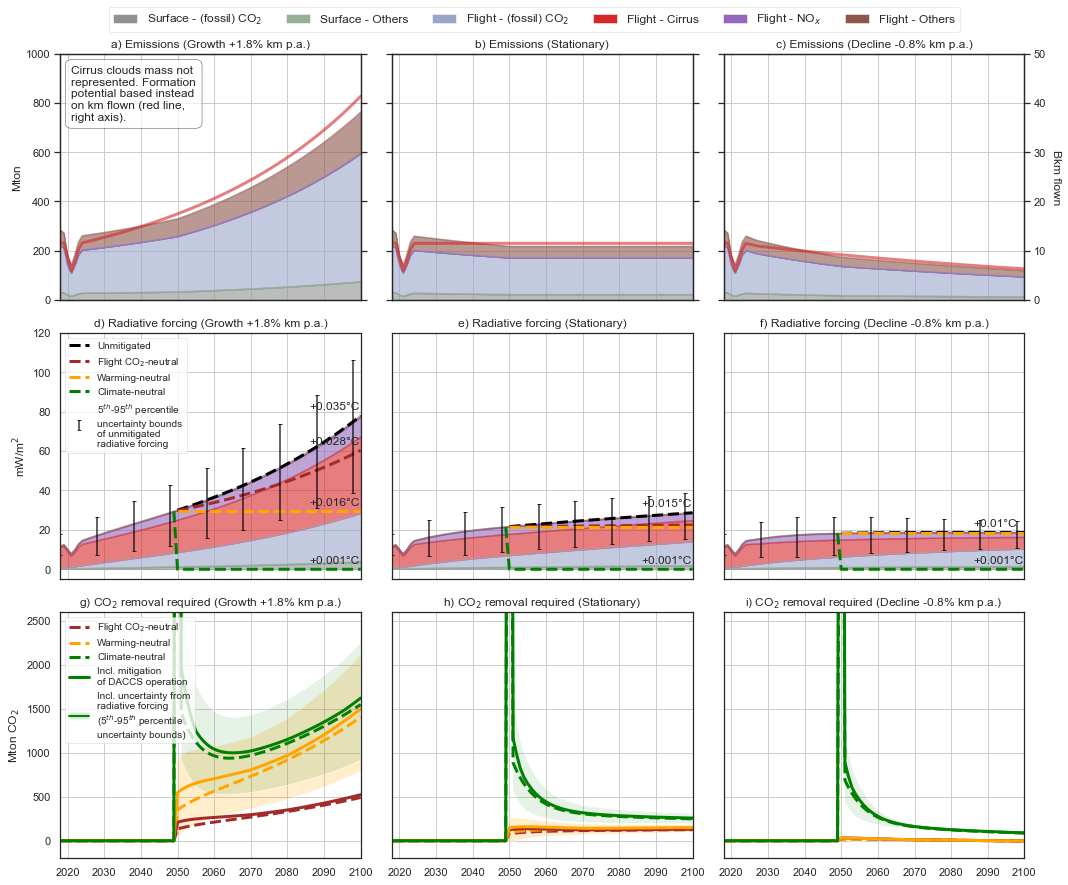

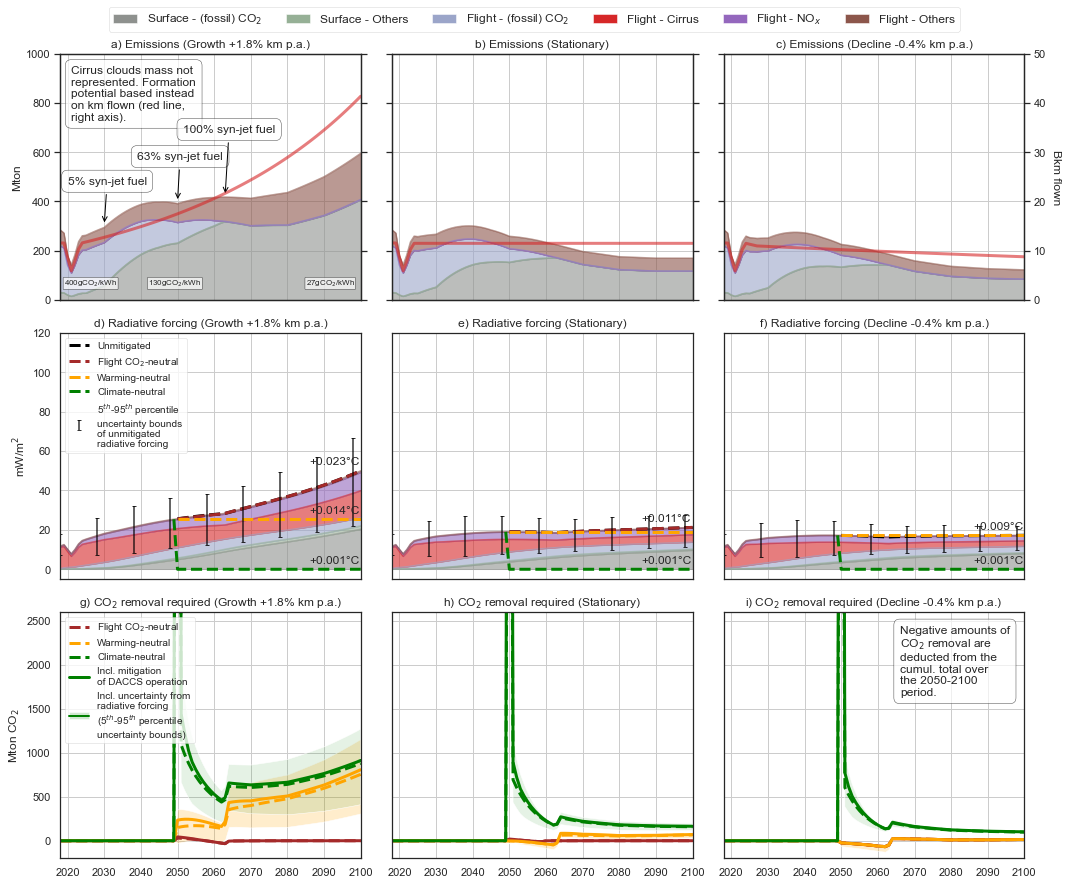

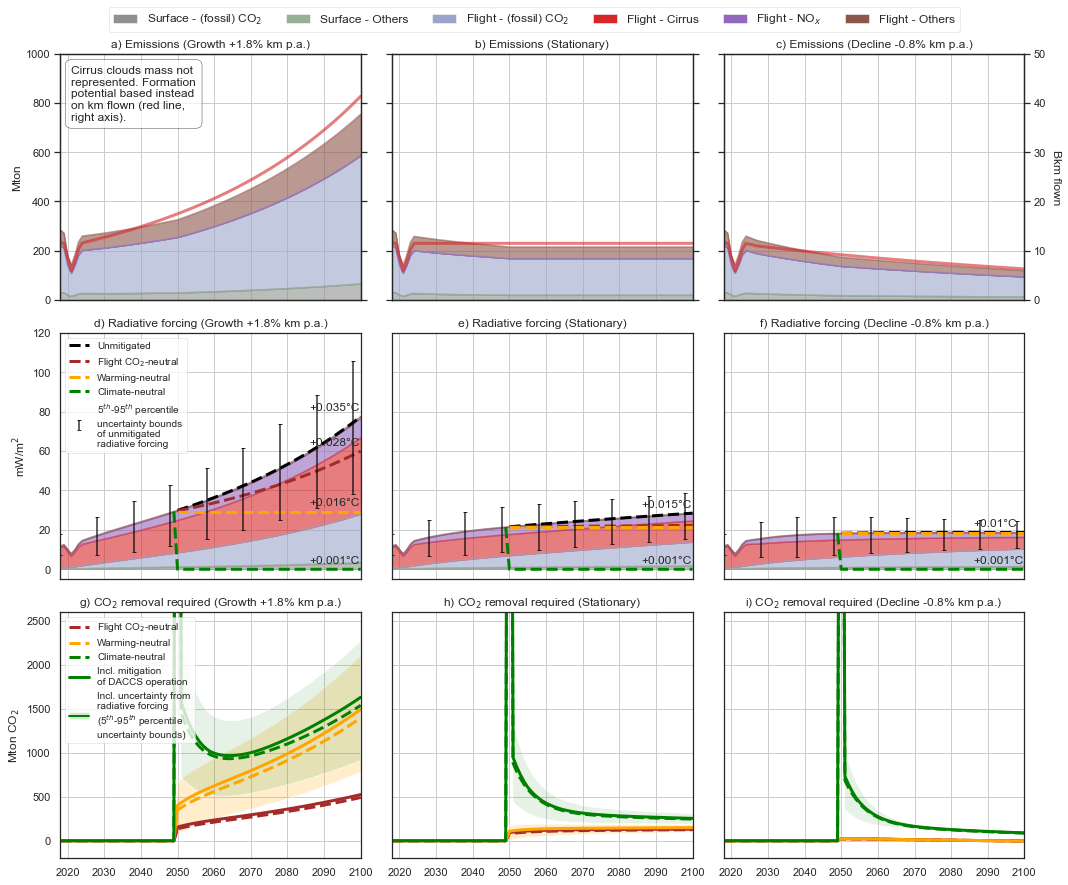

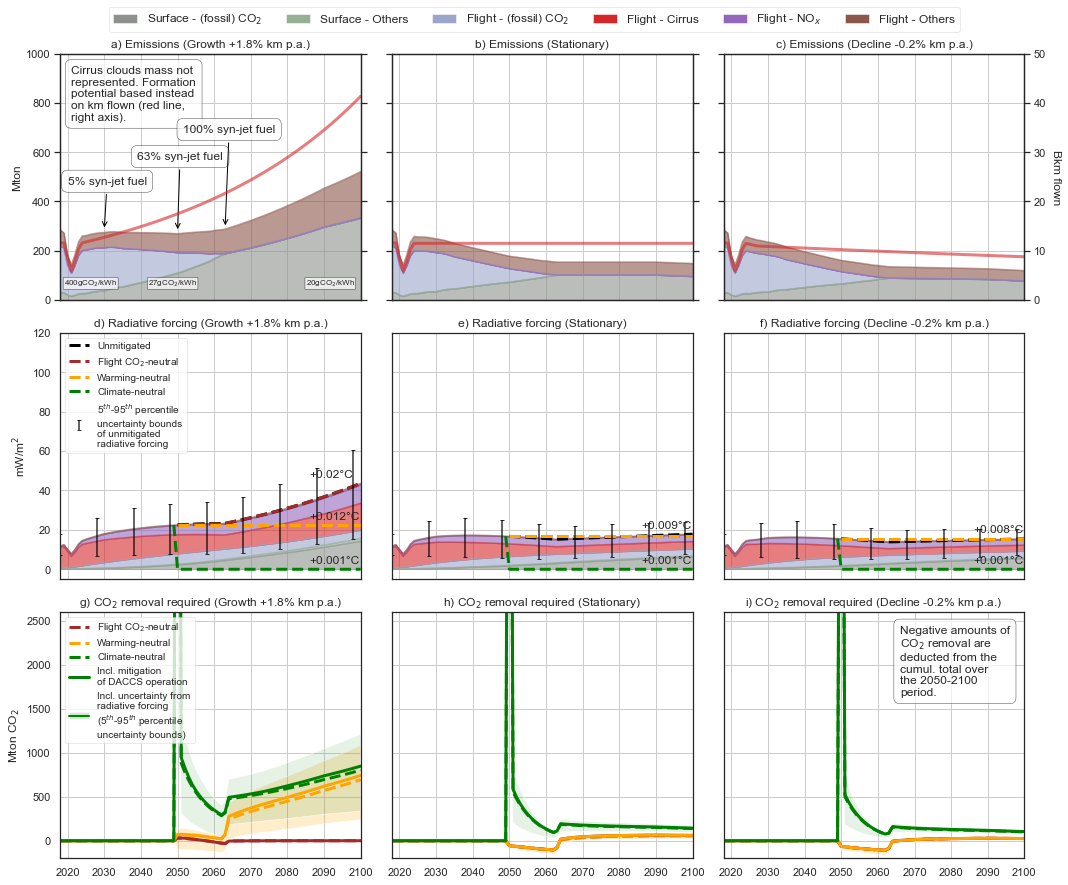

In [31]:
for background in [
    "Business As Usual", 
    "Paris Agreement"
]:

    for fuel in [
        "jet fuel", 
        "syn-jet fuel"
    ]:
        
        plt.rcParams["figure.figsize"] = (15, 12)
        fig, axs = plt.subplots(3, 3, sharex=True, sharey=False)
        # slice data of interest
        data = df.loc[(df["fuel"] == fuel)&(df["background"] == background), :'Cirrus']
        data = data.loc[data["Tg/year"].isin(range(start, end + 1))]
        
        scenarios = [
            "Growth",
            "Stationary",
            "Decline",
        ]

        metrics = [
            "Amount",
            "RF",
            "CDR",
        ]
        colors = [u'#8e918e', u'#96b096', u'#9ba5c9', u'#d62728', u'#9467bd', u'#8c564b']
        
        lines = [
            Patch(facecolor=colors[0],),
            Patch(facecolor=colors[1],),
            Patch(facecolor=colors[2],),
            Patch(facecolor=colors[3],),
            Patch(facecolor=colors[4],),
            Patch(facecolor=colors[5],)
            
        ]
        labels = [
            "Surface - (fossil) CO$_2$",
            "Surface - Others",
            "Flight - (fossil) CO$_2$",
            "Flight - Cirrus",
            "Flight - NO$_x$",
            "Flight - Others"
        ]
        
        plt.figlegend(lines, labels, loc ='upper center', ncol=6, labelspacing=0, fontsize=12, bbox_to_anchor=(0.5, 1.03))

        for s, scenario in enumerate(scenarios):
            for m, metric in enumerate(metrics):
                colors = [u'#8e918e', u'#96b096', u'#9ba5c9', u'#d62728', u'#9467bd', u'#8c564b']
                
                

                ############################## EMISSIONS ###################################################
                # plot annual emissions in Mtons
                if metric == "Amount":
                    
                    E = pd.DataFrame(
                        columns=[
                            "surface - CO2",
                            "surface - Others",
                            "flight - CO2",
                            "flight - Cirrus",
                            "flight - NOx",
                            "flight - Others"
                        ],
                        index = range(start, end + 1)
                    )
                    
                    for k, v in d_map.items():
                        if isinstance(v, list):
                            E.loc[:, k] = (data.loc[(data["scenario"]==scenario), v].sum(1) / 1e9).values
                        else:
                            E.loc[:, k] = (data.loc[(data["scenario"]==scenario), v] / 1e9).values
                    
                    l_E = [
                            "surface - CO2",
                            "surface - Others",
                            "flight - CO2",
                            "flight - NOx",
                            "flight - Others"
                        ]
                    E.loc[:, l_E].plot(
                        kind="area", 
                        ax=axs[m, s], 
                        alpha=alfa, 
                        color=[u'#8e918e', u'#96b096', u'#9ba5c9', u'#9467bd', u'#8c564b']
                    )
                    
                    ax2 = axs[m, s].twinx()
                    ax2.set_ylim(0, 50)
                    ax2.set_yticks(ax2.get_yticks()[:])
                    
                    ax2.plot(
                        range(2018, 2101),
                        data.loc[data["scenario"]==scenario, "km"]/1e9,
                        alpha=alfa, 
                        c=u'#d62728',
                        linewidth=3
                    )
                    
                    
                    axs[m, s].set_title(f"{scenario}")
                    axs[m, s].grid()
                    axs[m, s].legend().remove()
                        
                    if scenario == "Growth":
                        title = f"{title_labels[(background, scenario, metric)]} Emissions ({scenario} +1.8% km p.a.)"
                        
                    elif scenario == "Decline":
                        if fuel == "jet fuel":
                            if background=="Business As Usual":
                                title = f"{title_labels[(background, scenario, metric)]} Emissions ({scenario} -0.8% km p.a.)"
                            else:
                                title = f"{title_labels[(background, scenario, metric)]} Emissions ({scenario} -0.8% km p.a.)"
                        else:
                            if background=="Business As Usual":
                                title = f"{title_labels[(background, scenario, metric)]} Emissions ({scenario} -0.4% km p.a.)"
                            else:
                                title = f"{title_labels[(background, scenario, metric)]} Emissions ({scenario} -0.2% km p.a.)"
                            
                    else:
                        title = f"{title_labels[(background, scenario, metric)]} Emissions ({scenario})"
                        
                    axs[m, s].set_title(title)
                    axs[m, s].set_ylim(0, 1000)
                    
                    loc = plticker.MultipleLocator(base=10) # this locator puts ticks at regular intervals
                    axs[m, s].xaxis.set_major_locator(loc)
                    
                    if s == 0:
                        axs[m, s].set_ylabel("Mton", fontsize=12)
                        axs[m, s].annotate("Cirrus clouds mass not\nrepresented. Formation\npotential based instead\non km flown (red line,\nright axis).", 
                                           xy=(2021, 730),
                                          bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.7))
                        
                        if fuel == "syn-jet fuel":

                            axs[m, s].annotate("5% syn-jet fuel", 
                                               xy=(2030, E.loc[2030, :].sum()),
                                               xytext=(2020, 470),
                                               bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.7),
                                               arrowprops=dict(arrowstyle= '->',
                                                 color='black',
                                                 lw=1,
                                                 ls='-')
                            )
                            
                            axs[m, s].annotate("63% syn-jet fuel", 
                                               xy=(2050, E.loc[2050, :].sum()),
                                               xytext=(2039, 570),
                                               bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.7),
                                               arrowprops=dict(arrowstyle= '->',
                                                 color='black',
                                                 lw=1,
                                                 ls='-')
                            )
                            
                            axs[m, s].annotate("100% syn-jet fuel", 
                                               xy=(2063, E.loc[2063, :].sum()),
                                               xytext=(2051.5, 680),
                                               bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.7),
                                               arrowprops=dict(arrowstyle= '->',
                                                 color='black',
                                                 lw=1,
                                                 ls='-'),
                                               zorder=15
                            )
                            
                            if background == "Business As Usual":
                                vals = [400, 130, 27]
                            else:
                                vals = [400, 27, 20]
                            
                            
                            axs[m, s].annotate(f"{vals[0]}gCO$_2$/kWh",
                                               fontsize=8,
                                               xy=(2019, 60),
                                               bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1', alpha=0.7),
                                               
                            )
                            
                            axs[m, s].annotate(f"{vals[1]}gCO$_2$/kWh",
                                               fontsize=8,
                                               xy=(2042, 60),
                                               bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1', alpha=0.7),
                            )
                            
                            axs[m, s].annotate(f"{vals[2]}gCO$_2$/kWh",
                                               fontsize=8,
                                               xy=(2085, 60),
                                               bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.1', alpha=0.7),
                            )
                        
                    else:
                        axs[m, s].set_yticklabels([])
                    if s== 2:
                        ax2.set_ylabel("Bkm flown", rotation=270, labelpad=15, fontsize=12)
                    else:
                        ax2.set_yticklabels([])
                
                else:
                    ############################# RADIATIVE FORCING ############################################
                    # plot annual forcing, in mW/m^2
                    
                    RF = pd.DataFrame(
                        columns=[
                            "surface - CO2",
                            "surface - Others",
                            "flight - CO2",
                            "flight - Cirrus",
                            "flight - NOx",
                            "flight - Others"
                        ],
                        index = range(start, end + 1)
                    )
                    RF.loc[:, :] = 0
                    RF_low = RF.copy()
                    RF_high = RF.copy()
                    RF_low.loc[:, :] = 0
                    RF_high.loc[:, :] = 0
                    
                    for r in data.loc[:, 'HFC-152a': 'Cirrus'].columns:
                        if r not in ["CO2", "CO2 (flight)"]:
                            # Set to AR6 Values for substance
                            a_sub=a_ar5.copy()
                            a_sub[0:4]=[0,1.0,0,0]
                            a_sub[4]= 1 # Mt
                            a_sub[5:9]= [1, RF_lifetime[r], 1, 1]
                            a_sub[13]= RFI["medium"][r] / 1e3 # Radiative efficiency in W/m2/Mton
                            
                            a_sub_low = a_sub.copy()
                            a_sub_low[13] = RFI["low"][r] / 1e3 # Radiative efficiency in W/m2/Mton
                            
                            a_sub_high = a_sub.copy()
                            a_sub_high[13] = RFI["high"][r] / 1e3 # Radiative efficiency in W/m2/Mton

                            Fsub = EFmod(ny2, a_sub)
                            Fsub_low = EFmod(ny2, a_sub_low)
                            Fsub_high = EFmod(ny2, a_sub_high)
                            
                            if r != "Cirrus":
                                # LWE = FCO2^-1 * Fsub * Esub
                                RF.loc[:, d_map_rev[r]] += Fsub@(data.loc[(data["scenario"]==scenario), r] / 1e9 * 1e3) # <-- W to mW
                                RF_low.loc[:, d_map_rev[r]] += Fsub_low@(data.loc[(data["scenario"]==scenario), r] / 1e9 * 1e3) # <-- W to mW
                                RF_high.loc[:, d_map_rev[r]] += Fsub_high@(data.loc[(data["scenario"]==scenario), r] / 1e9 * 1e3) # <-- W to mW
                                
                            else:
                                RF.loc[:, "flight - Cirrus"] = (data.loc[(data["scenario"]==scenario), r]).values * RFI["medium"][r]
                                RF_low.loc[:, "flight - Cirrus"] = (data.loc[(data["scenario"]==scenario), r]).values * RFI["low"][r]
                                RF_high.loc[:, "flight - Cirrus"] = (data.loc[(data["scenario"]==scenario), r]).values * RFI["high"][r]
                                
                        else:
                            # LWE = FCO2^-1 * Fsub * Esub
                            RF.loc[:, d_map_rev[r]] = FCO2@(data.loc[(data["scenario"]==scenario), r] / 1e9).values # <-- W to mW
                            RF_low.loc[:, d_map_rev[r]] = FCO2@(data.loc[(data["scenario"]==scenario), r] / 1e9).values # <-- W to mW
                            RF_high.loc[:, d_map_rev[r]] = FCO2@(data.loc[(data["scenario"]==scenario), r] / 1e9).values # <-- W to mW
                        
                    
                    no_mitig = RF.copy()
                    no_mitig_low = RF_low.copy()
                    no_mitig_high = RF_high.copy()
                    
                    
                    only_CO2 = RF.copy()
                    only_CO2.loc[2050:, "flight - CO2"] = RF.loc[2049, "flight - CO2"]
                    
                    only_CO2_low = RF_low.copy()
                    only_CO2_low.loc[2050:, "flight - CO2"] = RF_low.loc[2049, "flight - CO2"]
                    
                    only_CO2_high = RF_high.copy()
                    only_CO2_high.loc[2050:, "flight - CO2"] = RF_high.loc[2049, "flight - CO2"]
                    
                    warming_neutral = RF.copy()
                    warming_neutral.loc[2050:] = warming_neutral.loc[2049, :].values[None, :]
                    
                    warming_neutral_low = RF_low.copy()
                    warming_neutral_low.loc[2050:] = warming_neutral_low.loc[2049, :].values[None, :]
                    
                    warming_neutral_high = RF_high.copy()
                    warming_neutral_high.loc[2050:] = warming_neutral_high.loc[2049, :].values[None, :]
                    
                    climate_neutral = RF.copy()
                    climate_neutral.loc[2050:] = 0
                    
                    climate_neutral_low = RF_low.copy()
                    climate_neutral_low.loc[2050:] = 0
                    
                    climate_neutral_high = RF_high.copy()
                    climate_neutral_high.loc[2050:] = 0
                    
                    only_CO2 = only_CO2.where(only_CO2 < no_mitig, no_mitig)
                    
                    if only_CO2.sum(1).sum() < warming_neutral.sum(1).sum():
                        only_CO2 -= (only_CO2 - warming_neutral)
                    
                    
                    if metric == "RF":
                        
                        RF.plot(ax=axs[m, s], kind="area", alpha=alfa, color=colors)
                        
                        axs[m, s].plot(no_mitig.loc[2050:].sum(1), linewidth=3, c= "black", label="Unmitigated", linestyle="--")
                        axs[m, s].plot(only_CO2.loc[2050:].sum(1), linewidth=3, c= "brown", label="Flight CO$_2$-neutral", linestyle="--")
                        axs[m, s].plot(warming_neutral.loc[2050:].sum(1), linewidth=3, c= "orange", label="Warming-neutral", linestyle="--")
                        axs[m, s].plot(climate_neutral.loc[2049:].sum(1), linewidth=3, c= "green", label="Climate-neutral", linestyle="--")
                    
                        ####### Uncertainty RF ##########################
                        
                        axs[m, s].errorbar(
                            x=range(start, end + 1), 
                            y=RF.sum(1), 
                            yerr=np.array([RF.sum(1) - RF_low.sum(1), RF_high.sum(1) - RF.sum(1)]),
                            linewidth=0,
                            elinewidth=1.5,
                            errorevery=10,
                            ecolor="black",
                            capsize=2,
                            alpha=.8,
                            label="5$^{th}$-95$^{th}$ percentile\nuncertainty bounds\nof unmitigated\nradiative forcing"
                        )
                        
                    
                        ####### Temp increase relative to 2018 ##########
                        colors = ["black", "orange", "green", "red"]
                        temp_res = []
                        for i, x in enumerate([no_mitig, only_CO2, warming_neutral, climate_neutral]):
                            # the whole 2018-2100 radiative forcing timeseries
                            d = RF.sum(1).copy()
                            
                            # from 2050 to 2100, we replace the RF valeus 
                            # with the RF from the mitigation pathway
                            d.loc[2050:] = x.sum(1)
                            
                            total_CO2 = (FCO2_inv@d) / 1e3
                            TCRE = 0.00045
                            temp = total_CO2.cumsum() * TCRE
                            temp = np.round(temp[-1], 3)
                            
                            if i == 3:
                                temp_list_res = []
                                temp_list_res.append(RF.sum(1).values.tolist())
                                temp_list_res.append(((FCO2_inv@RF.sum(1)) / 1e3).tolist())
                                temp_list_res.append(d.values.tolist())
                                temp_list_res.append(total_CO2.tolist())
                                temp_list_res.append(total_CO2.cumsum().tolist())
                            
                            if temp not in temp_res:
                                if not any(abs(temp-x) < .005 for x in temp_res):
                                    temp_res.append(temp)
                                    axs[m, s].annotate(f"+{temp}°C", xy=(2086, d[2100] + 3))
                                    
                    
                        if scenario == "Growth":
                            title = f"{title_labels[(background, scenario, metric)]} Radiative forcing ({scenario} +1.8% km p.a.)"

                        elif scenario == "Decline":
                            if fuel == "jet fuel":
                                if background=="Business As Usual":
                                    title = f"{title_labels[(background, scenario, metric)]} Radiative forcing ({scenario} -0.8% km p.a.)"
                                else:
                                    title = f"{title_labels[(background, scenario, metric)]} Radiative forcing ({scenario} -0.8% km p.a.)"

                            else:
                                if background=="Business As Usual":
                                    title = f"{title_labels[(background, scenario, metric)]} Radiative forcing ({scenario} -0.4% km p.a.)"
                                else:
                                    title = f"{title_labels[(background, scenario, metric)]} Radiative forcing ({scenario} -0.2% km p.a.)"

                        else:
                            title = f"{title_labels[(background, scenario, metric)]} Radiative forcing ({scenario})"
                            

                        axs[m, s].set_title(title)
                        axs[m, s].set_ylim(-5, 120)
                        axs[m, s].set_xlim(start, end)
                        axs[m, s].grid()

                        if s==0:
                            handles, labels = axs[m, s].get_legend_handles_labels()
                            axs[m, s].legend(handles=handles[6:], labels=labels[6:], loc="upper left", fontsize=10, ncol=1)

                        else:
                            axs[m, s].legend().remove()

                        if s == 0:
                            axs[m, s].set_ylabel("mW/m$^2$", fontsize=12)
                        else:
                            axs[m, s].set_yticklabels([])
                            
                    if metric == "CDR":
                        
                        
                        DAC_emissions = pd.DataFrame(np.zeros((len(range(start, end + 1)), len(col_tuples))), columns = col_tuples, index=range(start, end + 1))
                        DAC_emissions.columns = pd.MultiIndex.from_tuples(DAC_emissions.columns, names=['background','substance'])
                        DAC_emissions = DAC_emissions.drop(columns=('flight CO2-neutral','year'))
                        DAC_emissions = DAC_emissions.drop(columns=('warming-neutral','year'))
                        DAC_emissions = DAC_emissions.drop(columns=('climate-neutral','year'))
                        DAC_emissions.loc[:, :] = 0
                        DAC_emissions_low = DAC_emissions.copy()
                        DAC_emissions_high = DAC_emissions.copy()
                        DAC_emissions_low.loc[:, :] = 0
                        DAC_emissions_high.loc[:, :] = 0
                        DAC_RF = pd.DataFrame(np.zeros((len(range(start, end + 1)), len(col_tuples2))), columns = col_tuples2, index=range(start, end + 1))
                        DAC_RF.columns = pd.MultiIndex.from_tuples(DAC_RF.columns, names=['background','source'])
                        DAC_RF.loc[:, :] = 0
                        DAC_RF_low = DAC_RF.copy()
                        DAC_RF_high = DAC_RF.copy()
        
                        CDR_warming_neutral = pd.DataFrame(np.zeros_like(no_mitig), columns=no_mitig.columns, index=no_mitig.index)
                        CDR_warming_neutral = no_mitig - warming_neutral
                        #CDR_warming_neutral.loc[2018:2049] = 0
                        CDR_warming_neutral_low = pd.DataFrame(np.zeros_like(no_mitig_low), columns=no_mitig_low.columns, index=no_mitig_low.index)
                        CDR_warming_neutral_low = no_mitig_low - warming_neutral
                        #CDR_warming_neutral_low.loc[2018:2049] = 0
                        CDR_warming_neutral_high = pd.DataFrame(np.zeros_like(no_mitig_high), columns=no_mitig_high.columns, index=no_mitig_high.index)
                        CDR_warming_neutral_high = no_mitig_high - warming_neutral
                        #CDR_warming_neutral_high.loc[2018:2049] = 0
                        
                        CDR_only_CO2 = pd.DataFrame(np.zeros_like(no_mitig), columns=no_mitig.columns, index=no_mitig.index)
                        CDR_only_CO2 = no_mitig - only_CO2
                        #CDR_only_CO2.loc[2018:2049] = 0
                        
                        CDR_only_CO2_low = pd.DataFrame(np.zeros_like(no_mitig_low), columns=no_mitig_low.columns, index=no_mitig_low.index)
                        CDR_only_CO2_low = no_mitig_low - only_CO2
                        #CDR_only_CO2_low.loc[2018:2049] = 0
                        CDR_only_CO2_high = pd.DataFrame(np.zeros_like(no_mitig_high), columns=no_mitig_high.columns, index=no_mitig_high.index)
                        CDR_only_CO2_high = no_mitig_high - only_CO2
                        #CDR_only_CO2_high.loc[2018:2049] = 0
                        
                        
                        CDR_climate_neutral = pd.DataFrame(np.zeros_like(no_mitig), columns=no_mitig.columns, index=no_mitig.index)
                        CDR_climate_neutral = no_mitig.copy()
                        CDR_climate_neutral.loc[2018:2049] = 0
                        CDR_climate_neutral_low = pd.DataFrame(np.zeros_like(no_mitig_low), columns=no_mitig_low.columns, index=no_mitig_low.index)
                        CDR_climate_neutral_low = no_mitig_low.copy()
                        CDR_climate_neutral_low.loc[2018:2049] = 0
                        CDR_climate_neutral_high = pd.DataFrame(np.zeros_like(no_mitig_high), columns=no_mitig_high.columns, index=no_mitig_high.index)
                        CDR_climate_neutral_high = no_mitig_high.copy()
                        CDR_climate_neutral_high.loc[2018:2049] = 0


                        ######### fill in DAC ##########

                        DAC_emissions.loc[:, ("flight CO2-neutral", )] = (FCO2_inv@CDR_only_CO2).sum(1)[:, None] * dac.loc[dac["background"]==background, "HFC-152a":].values
                        DAC_emissions.loc[:, ("warming-neutral", )] = (FCO2_inv@CDR_warming_neutral).sum(1)[:, None] * dac.loc[dac["background"]==background, "HFC-152a":].values
                        DAC_emissions.loc[:, ("climate-neutral", )] = (FCO2_inv@CDR_climate_neutral).sum(1)[:, None] * dac.loc[dac["background"]==background, "HFC-152a":].values
                        
                        DAC_emissions_low.loc[:, ("flight CO2-neutral", )] = (FCO2_inv@CDR_only_CO2_low).sum(1)[:, None] * dac.loc[dac["background"]==background, "HFC-152a":].values
                        DAC_emissions_low.loc[:, ("warming-neutral", )] = (FCO2_inv@CDR_warming_neutral_low).sum(1)[:, None] * dac.loc[dac["background"]==background, "HFC-152a":].values
                        DAC_emissions_low.loc[:, ("climate-neutral", )] = (FCO2_inv@CDR_climate_neutral_low).sum(1)[:, None] * dac.loc[dac["background"]==background, "HFC-152a":].values
                        
                        DAC_emissions_high.loc[:, ("flight CO2-neutral", )] = (FCO2_inv@CDR_only_CO2_high).sum(1)[:, None] * dac.loc[dac["background"]==background, "HFC-152a":].values
                        DAC_emissions_high.loc[:, ("warming-neutral", )] = (FCO2_inv@CDR_warming_neutral_high).sum(1)[:, None] * dac.loc[dac["background"]==background, "HFC-152a":].values
                        DAC_emissions_high.loc[:, ("climate-neutral", )] = (FCO2_inv@CDR_climate_neutral_high).sum(1)[:, None] * dac.loc[dac["background"]==background, "HFC-152a":].values
                        
                        DAC_CO2 = DAC_RF.copy()
                        additional_DAC_CO2 = DAC_CO2.copy()
                        
                        DAC_CO2_low = DAC_RF_low.copy()
                        additional_DAC_CO2_low = DAC_CO2_low.copy()
                        
                        DAC_CO2_high = DAC_RF_high.copy()
                        additional_DAC_CO2_high = DAC_CO2_high.copy()
                        
                        only_CO2_total = (FCO2_inv@CDR_only_CO2)
                        only_CO2_total.loc[2018:2049] = 0
                        axs[m, s].plot(range(start, end + 1), 
                                       only_CO2_total.sum(1), 
                                       c= "brown", linestyle="--", 
                                       label="Flight CO$_2$-neutral", linewidth=3
                                      )
                        
                        
                        warming_neutral_total = (FCO2_inv@CDR_warming_neutral)
                        warming_neutral_total.index = range(start, end + 1)
                        warming_neutral_total_low = (FCO2_inv@CDR_warming_neutral_low)
                        warming_neutral_total_low.index = range(start, end + 1)
                        warming_neutral_total_high = (FCO2_inv@CDR_warming_neutral_high)
                        warming_neutral_total_high.index = range(start, end + 1)
                        
                        warming_neutral_total.loc[2018:2049] = 0
                        warming_neutral_total_low.loc[2018:2049] = 0
                        warming_neutral_total_high.loc[2018:2049] = 0
                        
                        axs[m, s].plot(range(start, end + 1), 
                                       warming_neutral_total.sum(1), 
                                       c= "orange", linestyle="--",
                                label="Warming-neutral", linewidth=3
                                      )
                        
                        climate_neutral_total = (FCO2_inv@CDR_climate_neutral)
                        climate_neutral_total.index = range(start, end + 1)
                        climate_neutral_total_low = (FCO2_inv@CDR_climate_neutral_low)
                        climate_neutral_total_low.index = range(start, end + 1)
                        climate_neutral_total_high = (FCO2_inv@CDR_climate_neutral_high)
                        climate_neutral_total_high.index = range(start, end + 1)
                        climate_neutral_total.loc[2018:2048] = 0
                        climate_neutral_total_low.loc[2018:2048] = 0
                        climate_neutral_total_high.loc[2018:2048] = 0
                        
                        axs[m, s].plot(range(start, end + 1), 
                                       climate_neutral_total.sum(1),  
                                       c= "green", linestyle="--",
                                label="Climate-neutral", linewidth=3)
                        
                        
                        while DAC_emissions.sum(0).sum() >= .001:
                            for trajectory in ["flight CO2-neutral", "warming-neutral", "climate-neutral"]:
                                for r in DAC_emissions.loc[:, (trajectory, )].columns:
                                    if r in d_map_rev:
                                        if DAC_emissions.loc[:, (trajectory, r)].sum(0) > 0:

                                            if r not in ["CO2",]:

                                                # Set to AR6 Values for substance
                                                a_sub=a_ar5.copy()
                                                a_sub[0:4]=[0,1.0,0,0]
                                                a_sub[4]= 1 # Mt
                                                a_sub[5:9]= [1, RF_lifetime[r], 1, 1]
                                                a_sub[13]= RFI["medium"][r] / 1e3 # Radiative efficiency in W/m2/Mton  

                                                a_sub_low = a_sub.copy()
                                                a_sub_low[13] = RFI["low"][r] / 1e3 # Radiative efficiency in W/m2/Mton

                                                a_sub_high = a_sub.copy()
                                                a_sub_high[13] = RFI["high"][r] / 1e3 # Radiative efficiency in W/m2/Mton

                                                Fsub = EFmod(ny2, a_sub)
                                                Fsub_low = EFmod(ny2, a_sub_low)
                                                Fsub_high = EFmod(ny2, a_sub_high)

                                                # LWE = FCO2^-1 * Fsub * Esub
                                                DAC_RF.loc[:, (trajectory, d_map_rev[r])] += Fsub@DAC_emissions.loc[:, (trajectory, r)] * 1e3 # <-- W to mW
                                                DAC_RF_low.loc[:, (trajectory, d_map_rev[r])] += Fsub_low@DAC_emissions_low.loc[:, (trajectory, r)] * 1e3 # <-- W to mW
                                                DAC_RF_high.loc[:, (trajectory, d_map_rev[r])] += Fsub_high@DAC_emissions_high.loc[:, (trajectory, r)] * 1e3 # <-- W to mW

                                            else:
                                                # LWE = FCO2^-1 * Fsub * Esub
                                                DAC_RF.loc[:, (trajectory, d_map_rev[r])] = FCO2@DAC_emissions.loc[:, (trajectory, r)] # <-- W to mW
                                                DAC_RF_low.loc[:, (trajectory, d_map_rev[r])] = FCO2@DAC_emissions_low.loc[:, (trajectory, r)] # <-- W to mW
                                                DAC_RF_high.loc[:, (trajectory, d_map_rev[r])] = FCO2@DAC_emissions_high.loc[:, (trajectory, r)] # <-- W to mW

                                            
                                            DAC_CO2.loc[:, (trajectory, d_map_rev[r])] += FCO2_inv@DAC_RF.loc[:, (trajectory, d_map_rev[r])]
                                            DAC_CO2_low.loc[:, (trajectory, d_map_rev[r])] += FCO2_inv@DAC_RF_low.loc[:, (trajectory, d_map_rev[r])]
                                            DAC_CO2_high.loc[:, (trajectory, d_map_rev[r])] += FCO2_inv@DAC_RF_high.loc[:, (trajectory, d_map_rev[r])]

                            # subtract emissions captures
                            DAC_emissions.loc[:, ("flight CO2-neutral", )] -= DAC_CO2.loc[:, ("flight CO2-neutral")]
                            DAC_emissions.loc[:, ("warming-neutral", )] -= DAC_CO2.loc[:, ("warming-neutral")]
                            DAC_emissions.loc[:, ("climate-neutral", )] -= DAC_CO2.loc[:, ("climate-neutral")]
                            
                            DAC_emissions_low.loc[:, ("flight CO2-neutral", )] -= DAC_CO2_low.loc[:, ("flight CO2-neutral")]
                            DAC_emissions_low.loc[:, ("warming-neutral", )] -= DAC_CO2_low.loc[:, ("warming-neutral")]
                            DAC_emissions_low.loc[:, ("climate-neutral", )] -= DAC_CO2_low.loc[:, ("climate-neutral")]
                            
                            DAC_emissions_high.loc[:, ("flight CO2-neutral", )] -= DAC_CO2_high.loc[:, ("flight CO2-neutral")]
                            DAC_emissions_high.loc[:, ("warming-neutral", )] -= DAC_CO2_high.loc[:, ("warming-neutral")]
                            DAC_emissions_high.loc[:, ("climate-neutral", )] -= DAC_CO2_high.loc[:, ("climate-neutral")]
                            
                            # add new emissions from DACCS
                            DAC_emissions.loc[:, ("flight CO2-neutral", )] = (DAC_CO2.loc[:, ("flight CO2-neutral")].sum(1)[:, None] * dac.loc[dac["background"]==background, "HFC-152a":].values)
                            DAC_emissions.loc[:, ("warming-neutral", )] = (DAC_CO2.loc[:, ("warming-neutral")].sum(1)[:, None] * dac.loc[dac["background"]==background, "HFC-152a":].values)
                            DAC_emissions.loc[:, ("climate-neutral", )] = (DAC_CO2.loc[:, ("climate-neutral")].sum(1)[:, None] * dac.loc[dac["background"]==background, "HFC-152a":].values)
                            
                            DAC_emissions_low.loc[:, ("flight CO2-neutral", )] = (DAC_CO2_low.loc[:, ("flight CO2-neutral")].sum(1)[:, None] * dac.loc[dac["background"]==background, "HFC-152a":].values)
                            DAC_emissions_low.loc[:, ("warming-neutral", )] = (DAC_CO2_low.loc[:, ("warming-neutral")].sum(1)[:, None] * dac.loc[dac["background"]==background, "HFC-152a":].values)
                            DAC_emissions_low.loc[:, ("climate-neutral", )] = (DAC_CO2_low.loc[:, ("climate-neutral")].sum(1)[:, None] * dac.loc[dac["background"]==background, "HFC-152a":].values)
                            
                            DAC_emissions_high.loc[:, ("flight CO2-neutral", )] = (DAC_CO2_high.loc[:, ("flight CO2-neutral")].sum(1)[:, None] * dac.loc[dac["background"]==background, "HFC-152a":].values)
                            DAC_emissions_high.loc[:, ("warming-neutral", )] = (DAC_CO2_high.loc[:, ("warming-neutral")].sum(1)[:, None] * dac.loc[dac["background"]==background, "HFC-152a":].values)
                            DAC_emissions_high.loc[:, ("climate-neutral", )] = (DAC_CO2_high.loc[:, ("climate-neutral")].sum(1)[:, None] * dac.loc[dac["background"]==background, "HFC-152a":].values)
                            
                            additional_DAC_CO2 += DAC_CO2
                            DAC_CO2.loc[:, :] = 0
                            DAC_RF.loc[:, :] = 0
                            
                            additional_DAC_CO2_low += DAC_CO2_low
                            DAC_CO2_low.loc[:, :] = 0
                            DAC_RF_low.loc[:, :] = 0
                            
                            additional_DAC_CO2_high += DAC_CO2_high
                            DAC_CO2_high.loc[:, :] = 0
                            DAC_RF_high.loc[:, :] = 0
                            
                            
                        
                        additional_DAC_CO2.loc[2018:2049] = 0
                        additional_DAC_CO2_low.loc[2018:2049] = 0
                        additional_DAC_CO2_high.loc[2018:2049] = 0
                        
                        only_CO2_total += np.clip(additional_DAC_CO2.loc[:, ("flight CO2-neutral", )].values, 0, None)
                        
                        warming_neutral_total += np.clip(additional_DAC_CO2.loc[:, ("warming-neutral", )].values, 0, None)
                        warming_neutral_total_low += np.clip(additional_DAC_CO2_low.loc[:, ("warming-neutral", )].values, 0, None)
                        warming_neutral_total_high += np.clip(additional_DAC_CO2_high.loc[:, ("warming-neutral", )].values, 0, None)
                        
                        climate_neutral_total += np.clip(additional_DAC_CO2.loc[:, ("climate-neutral", )].values, 0, None)
                        climate_neutral_total_low += np.clip(additional_DAC_CO2_low.loc[:, ("climate-neutral", )].values, 0, None)
                        climate_neutral_total_high += np.clip(additional_DAC_CO2_high.loc[:, ("climate-neutral", )].values, 0, None)
                        
                        
                        axs[m, s].plot(range(start, end + 1), 
                                       only_CO2_total.sum(1), 
                                       c= "brown", linestyle="-", 
                                       label="Flight CO$_2$-neutral", 
                                       linewidth=3
                                      )
                        
                        axs[m, s].plot(range(start, end + 1), 
                                       warming_neutral_total.sum(1), 
                                       c= "orange", linestyle="-",
                                        label="Warming-neutral", linewidth=3
                                      )
                        
                        
                        axs[m, s].fill_between(range(start, end + 1),
                                warming_neutral_total_low.sum(1),
                                warming_neutral_total_high.sum(1),
                                facecolor= (1.0, 0.647, 0.0, .2),
                                edgecolor=None
                          )
                       
                        
                        axs[m, s].plot(range(start, end + 1), 
                                       climate_neutral_total.sum(1), 
                                       c= "green", linestyle="-",
                                    label="Incl. mitigation\nof DACCS operation", linewidth=3)
                        
                        axs[m, s].fill_between(range(start, end + 1),
                                climate_neutral_total_low.sum(1),
                                climate_neutral_total_high.sum(1),
                                facecolor= (0.0, 0.50196, 0.0, .1),
                                edgecolor=None
                                
                            )
                        
                        
                        axs[m, s].set_xlim(start, end)
                        axs[m, s].set_ylim(-200, 2600)
                        
                        if scenario == "Growth":
                            title = f"{title_labels[(background, scenario, metric)]} CO$_2$ removal required ({scenario} +1.8% km p.a.)"
                        elif scenario == "Decline":
                            if fuel == "jet fuel":
                                if background=="Business As Usual":
                                    title = f"{title_labels[(background, scenario, metric)]} CO$_2$ removal required ({scenario} -0.8% km p.a.)"
                                else:
                                    title = f"{title_labels[(background, scenario, metric)]} CO$_2$ removal required ({scenario} -0.8% km p.a.)"
                            else:
                                if background=="Business As Usual":
                                    title = f"{title_labels[(background, scenario, metric)]} CO$_2$ removal required ({scenario} -0.4% km p.a.)"
                                else:
                                    title = f"{title_labels[(background, scenario, metric)]} CO$_2$ removal required ({scenario} -0.2% km p.a.)"
                        else:
                            title = f"{title_labels[(background, scenario, metric)]} CO$_2$ removal required ({scenario})"

                        axs[m, s].set_title(title)

                        if s == 0:
                            axs[m, s].set_ylabel("Mton CO$_2$", fontsize=12)
                        else:
                            axs[m, s].set_yticklabels([])
                        axs[m, s].grid()

                        if s==0:
                            
                            
                            handles, labels = axs[m, s].get_legend_handles_labels()
                            handles = handles
                            
                            x = np.array([0, 1])
                            y = x + 1
                            
                            p3 = axs[m, s].plot(x, y, color=(0.0, 0.50196, 0.0, 1), linewidth=2, linestyle="-", label="bla")
                            p4 = axs[m, s].fill(np.NaN, np.NaN, facecolor=(0.0, 0.50196, 0.0, .18))
                            
                            handles.append((p4[0], p3[0]))
                            labels.append("Incl. uncertainty from\nradiative forcing\n(5$^{th}$-95$^{th}$ percentile\nuncertainty bounds)")
                            
                            handles = list(handles[i] for i in [0, 1, 2, 5, 6])
                            labels = list(labels[i] for i in [0, 1, 2, 5, 6])
                            
                            
                            axs[m, s].legend(handles=handles, labels=labels, loc="upper left", ncol=1, fontsize=10,)
                            
                            
                        else:
                            axs[m, s].legend().remove()
                            
                        if s == 2:
                            if fuel == "syn-jet fuel":
                                axs[m, s].annotate("Negative amounts of\nCO$_2$ removal are\ndeducted from the\ncumul. total over\nthe 2050-2100\nperiod.", 
                                               xy=(2066, 1650),
                                              bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.7))
                            
                            
                            
                        ############## RESULTS STORAGE #############
                        #print(fuel, background, scenario)
                        
                        for trajectory in ["flight CO2-neutral", "warming-neutral", "climate-neutral"]:
                            for case in ["low", "medium", "high"]:
                                
                                surplus_DAC = 0
                                storage = 0
                                
                                df_results.loc[
                                    (df_results["background"] == background)
                                    &(df_results["scenario"] == scenario)
                                    &(df_results["fuel"] == fuel)
                                    &(df_results["case"] == case)
                                    &(df_results["mitigation"] == trajectory),
                                    "LOP - infras.":'cost - compensation'
                                ] = df.loc[
                                    (df["fuel"] == fuel)
                                    &(df["background"] == background)
                                    &(df["scenario"]== scenario), 
                                    'LOP - infras.':'cost - compensation'
                                ].values
                                
                                if trajectory == "flight CO2-neutral":
                                    if case == "low":
                                        surplus_DAC = (only_CO2_total.sum(1)[:, None] * dac.loc[dac["background"]==background, "LOP - infras.":]) * 1e9
                                        storage_surface = only_CO2_total.loc[:, ['surface - CO2', 'surface - Others']].sum(1) * 1e9
                                        storage_flight = only_CO2_total.loc[:, ['flight - CO2', 'flight - Cirrus', 'flight - NOx', 'flight - Others']].sum(1) * 1e9
                                        storage_DACCS = additional_DAC_CO2.loc[:, ("flight CO2-neutral", )].sum(1) * 1e9
                                    elif case == "medium":
                                        surplus_DAC = (only_CO2_total.sum(1)[:, None] * dac.loc[dac["background"]==background, "LOP - infras.":]) * 1e9
                                        storage_surface = only_CO2_total.loc[:, ['surface - CO2', 'surface - Others']].sum(1) * 1e9
                                        storage_flight = only_CO2_total.loc[:, ['flight - CO2', 'flight - Cirrus', 'flight - NOx', 'flight - Others']].sum(1) * 1e9
                                        storage_DACCS = additional_DAC_CO2.loc[:, ("flight CO2-neutral", )].sum(1) * 1e9
                                    else:
                                        surplus_DAC = (only_CO2_total.sum(1)[:, None] * dac.loc[dac["background"]==background, "LOP - infras.":]) * 1e9
                                        storage_surface = only_CO2_total.loc[:, ['surface - CO2', 'surface - Others']].sum(1) * 1e9
                                        storage_flight = only_CO2_total.loc[:, ['flight - CO2', 'flight - Cirrus', 'flight - NOx', 'flight - Others']].sum(1) * 1e9
                                        storage_DACCS = additional_DAC_CO2.loc[:, ("flight CO2-neutral", )].sum(1) * 1e9
                                    
                                elif trajectory == "warming-neutral":
                                    if case == "low":
                                        surplus_DAC = (warming_neutral_total_low.sum(1)[:, None] * dac.loc[dac["background"]==background, "LOP - infras.":]) * 1e9
                                        storage_surface = warming_neutral_total_low.loc[:, ['surface - CO2', 'surface - Others']].sum(1) * 1e9
                                        storage_flight = warming_neutral_total_low.loc[:, ['flight - CO2', 'flight - Cirrus', 'flight - NOx', 'flight - Others']].sum(1) * 1e9
                                        storage_DACCS = additional_DAC_CO2_low.loc[:, ("warming-neutral", )].sum(1) * 1e9
                                    elif case=="medium":
                                        surplus_DAC = (warming_neutral_total.sum(1)[:, None] * dac.loc[dac["background"]==background, "LOP - infras.":]) * 1e9
                                        storage_surface = warming_neutral_total.loc[:, ['surface - CO2', 'surface - Others']].sum(1) * 1e9
                                        storage_flight = warming_neutral_total.loc[:, ['flight - CO2', 'flight - Cirrus', 'flight - NOx', 'flight - Others']].sum(1) * 1e9
                                        storage_DACCS = additional_DAC_CO2.loc[:, ("warming-neutral", )].sum(1) * 1e9
                                    else:
                                        surplus_DAC = (warming_neutral_total_high.sum(1)[:, None] * dac.loc[dac["background"]==background, "LOP - infras.":]) * 1e9
                                        storage_surface = warming_neutral_total_high.loc[:, ['surface - CO2', 'surface - Others']].sum(1) * 1e9
                                        storage_flight = warming_neutral_total_high.loc[:, ['flight - CO2', 'flight - Cirrus', 'flight - NOx', 'flight - Others']].sum(1) * 1e9
                                        storage_DACCS = additional_DAC_CO2_high.loc[:, ("warming-neutral", )].sum(1) * 1e9
                                else:
                                    if case == "low":
                                        surplus_DAC = (climate_neutral_total_low.sum(1)[:, None] * dac.loc[dac["background"]==background, "LOP - infras.":]) * 1e9
                                        storage_surface = climate_neutral_total_low.loc[:, ['surface - CO2', 'surface - Others']].sum(1) * 1e9
                                        storage_flight = climate_neutral_total_low.loc[:, ['flight - CO2', 'flight - Cirrus', 'flight - NOx', 'flight - Others']].sum(1) * 1e9
                                        storage_DACCS = additional_DAC_CO2_low.loc[:, ("climate-neutral", )].sum(1) * 1e9
                                    elif case =="medium":
                                        surplus_DAC = (climate_neutral_total.sum(1)[:, None] * dac.loc[dac["background"]==background, "LOP - infras.":]) * 1e9
                                        storage_surface = climate_neutral_total.loc[:, ['surface - CO2', 'surface - Others']].sum(1) * 1e9
                                        storage_flight = climate_neutral_total.loc[:, ['flight - CO2', 'flight - Cirrus', 'flight - NOx', 'flight - Others']].sum(1) * 1e9
                                        storage_DACCS = additional_DAC_CO2.loc[:, ("climate-neutral", )].sum(1) * 1e9
                                    else:
                                        surplus_DAC = (climate_neutral_total_high.sum(1)[:, None] * dac.loc[dac["background"]==background, "LOP - infras.":]) * 1e9
                                        storage_surface = climate_neutral_total_high.loc[:, ['surface - CO2', 'surface - Others']].sum(1) * 1e9
                                        storage_flight = climate_neutral_total_high.loc[:, ['flight - CO2', 'flight - Cirrus', 'flight - NOx', 'flight - Others']].sum(1) * 1e9
                                        storage_DACCS = additional_DAC_CO2_high.loc[:, ("climate-neutral", )].sum(1) * 1e9
                                        
                                df_results.loc[
                                    (df_results["background"] == background)
                                    &(df_results["scenario"] == scenario)
                                    &(df_results["fuel"] == fuel)
                                    &(df_results["case"] == case)
                                    &(df_results["mitigation"] == trajectory),
                                    "LOP - infras.":'cost - compensation'
                                ] += surplus_DAC.values
                                
                                
                                df_results.loc[
                                    (df_results["background"] == background)
                                    &(df_results["scenario"] == scenario)
                                    &(df_results["fuel"] == fuel)
                                    &(df_results["case"] == case)
                                    &(df_results["mitigation"] == trajectory),
                                    "storage - surface"
                                ] = storage_surface.values
                                
                                df_results.loc[
                                    (df_results["background"] == background)
                                    &(df_results["scenario"] == scenario)
                                    &(df_results["fuel"] == fuel)
                                    &(df_results["case"] == case)
                                    &(df_results["mitigation"] == trajectory),
                                    "storage - flight"
                                ] = storage_flight.values
                                
                                df_results.loc[
                                    (df_results["background"] == background)
                                    &(df_results["scenario"] == scenario)
                                    &(df_results["fuel"] == fuel)
                                    &(df_results["case"] == case)
                                    &(df_results["mitigation"] == trajectory),
                                    "storage - compensation"
                                ] = storage_DACCS.values
                                                 
        plt.tight_layout()
        plt.savefig(f"figures/surface_SLCP_{background}_{fuel}_2100.png", dpi=300, bbox_inches='tight',)
        plt.savefig(f"figures/surface_SLCP_{background}_{fuel}_2100.svg", bbox_inches='tight',)
        plt.savefig(f"figures/surface_SLCP_{background}_{fuel}_2100.eps", bbox_inches='tight', format='eps')
        plt.savefig(f"figures/surface_SLCP_{background}_{fuel}_2100.pdf", bbox_inches='tight', format='pdf')

# Figure 4

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


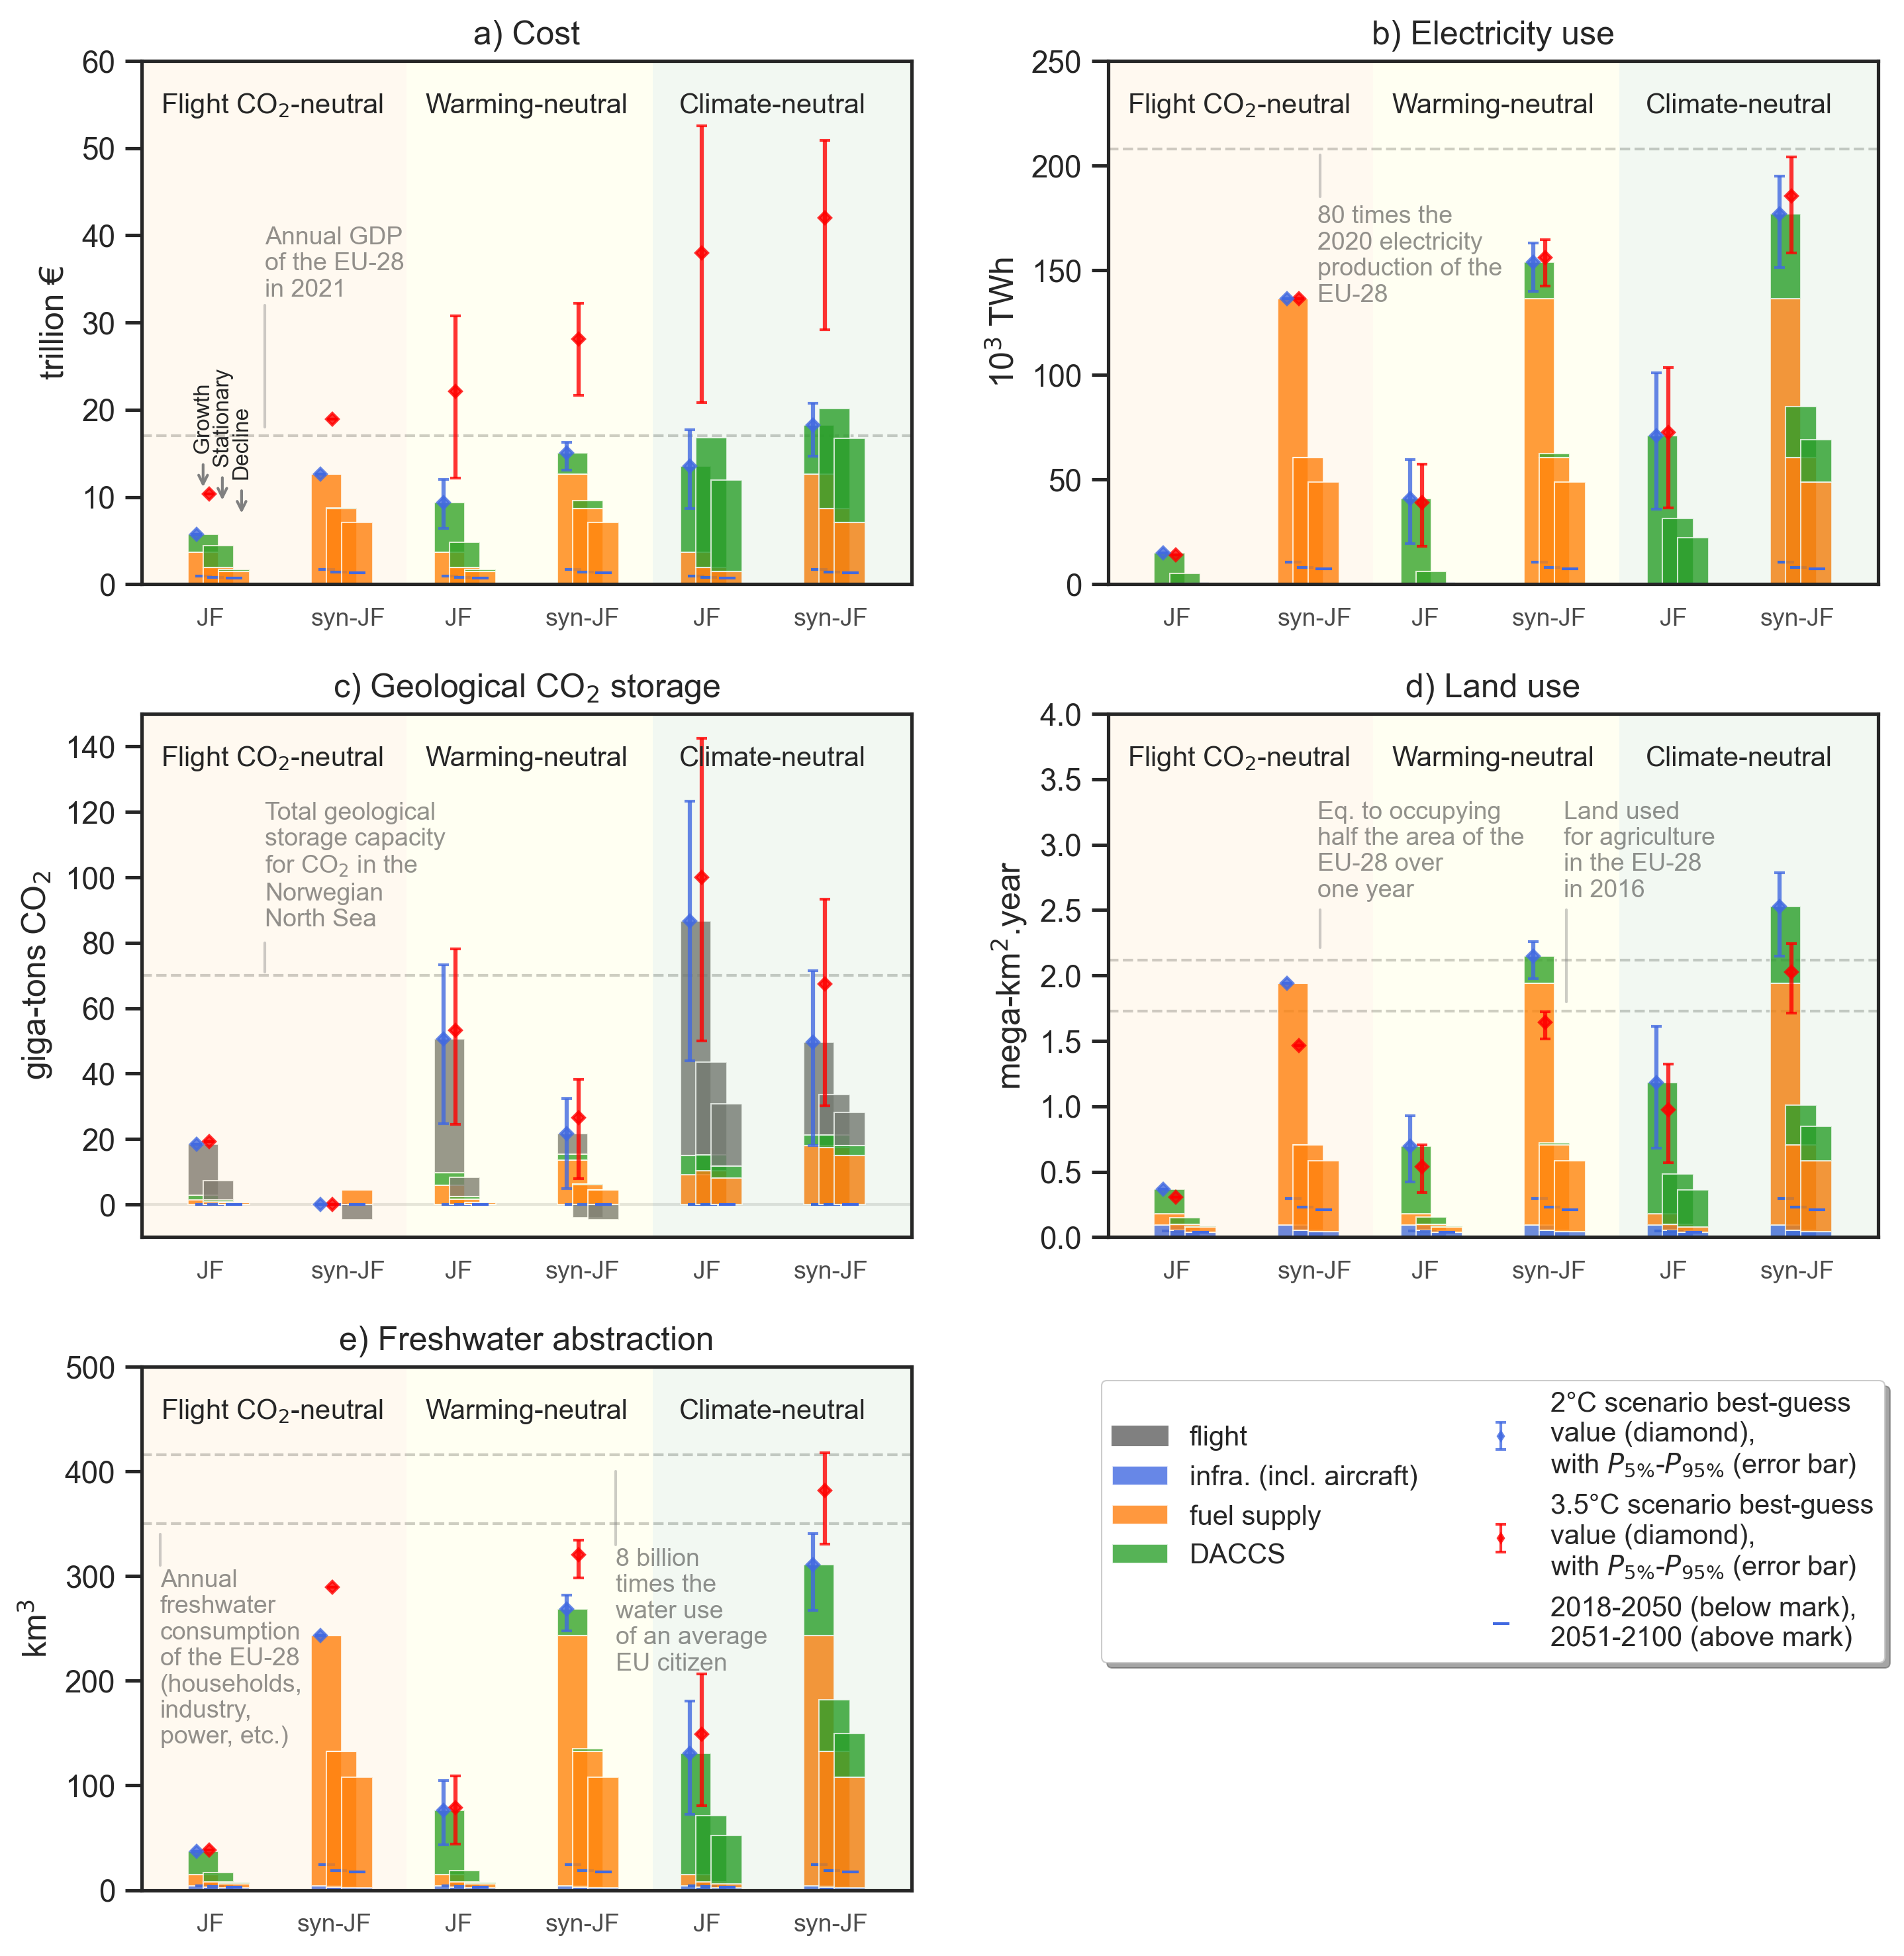

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

%matplotlib inline
sns.set_theme(style="white")
sns.set_context(rc = {'patch.linewidth': 0.5})

plt.rcParams["figure.figsize"] = (10, 10)
fig, axs = plt.subplots(3, 2, sharex=False, sharey=False)

d_cols = {
    "Cost": ['cost - infras.', 'cost - fuel supply', 'cost - compensation'],
    "Electricity": ['electricity - infras.', 'electricity - fuel supply', 'electricity - compensation'],
    "CO2 storage": ['storage - infras.', 'storage - surface', 'storage - compensation', 'storage - flight', ],
    "Land use": ['LOP - infras.', 'LOP - fuel supply', 'LOP - compensation'],
    "Freshwater abstraction": ['FWD - infras.', 'FWD - fuel supply', 'FWD - compensation']
}


row = 0
col = 0

colors = ['royalblue', u'#ff7f0e', u'#2ca02c', u'#7a7977', u'#7a7977', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']

for c, category in enumerate([
    "Cost",
    "Electricity",
    "CO2 storage",
    "Land use",
    "Freshwater abstraction"
]):
    if c > 0:
        if c % 2 == 0:
            row += 1
            col = 0
        else:
            col += 1
    
    
    data = df_results.loc[:, ["background", "scenario", "fuel", "case", "mitigation"] + d_cols[category]]
    
    
    if category=="Cost":
        # 1e12: € to trillion €
        data.loc[:, d_cols[category]] /= 1e12
        axs[row, col].set_ylim(0, 60)
        
    if category=="Electricity":
        # 1e12: kWh to 1000 TWh
        data.loc[:, d_cols[category]] /= 1e12
        axs[row, col].set_ylim(0, 250)
        
    if category=="CO2 storage":
        # 1e12: kg to Gtons
        data.loc[:, d_cols[category]] /= 1e12
        axs[row, col].set_ylim(0, 1.5e2)
        
    if category=="Land use":
        # 1e6: m2 to km2
        # 1e6: m2 to Mkm2
        data.loc[:, d_cols[category]] /= 1e12
        axs[row, col].set_ylim(0, 4.0e0)
        
    if category=="Freshwater abstraction":
        # 1e9: m3 to km3
        data.loc[:, d_cols[category]] /= 1e9
        axs[row, col].set_ylim(0, 500)
        
        
        
    for s in [
        ("Business As Usual", "red", -0.05),
        ("Paris Agreement", "royalblue", 0.05)
    ]:
    
        data_plot_growth = data.loc[(data["background"]==s[0])
                 &(data["scenario"]=="Growth")
                 &(data["case"]=="medium")
                 , :].groupby(["mitigation", "fuel"]).sum().loc[:, d_cols[category]]
        data_plot_growth = data_plot_growth.reindex(['flight CO2-neutral', 'warming-neutral', 'climate-neutral'], level='mitigation')


        data_plot_growth_low = data.loc[(data["background"]==s[0])
                 &(data["scenario"]=="Growth")
                 &(data["case"]=="low")
                 , :].groupby(["mitigation", "fuel"]).sum().loc[:, d_cols[category]]
        data_plot_growth_low = data_plot_growth_low.reindex(['flight CO2-neutral', 'warming-neutral', 'climate-neutral'], level='mitigation')
        
        data_plot_growth_high = data.loc[(data["background"]==s[0])
                 &(data["scenario"]=="Growth")
                 &(data["case"]=="high")
                 , :].groupby(["mitigation", "fuel"]).sum().loc[:, d_cols[category]]
        data_plot_growth_high = data_plot_growth_high.reindex(['flight CO2-neutral', 'warming-neutral', 'climate-neutral'], level='mitigation')
        
        data_plot_stationary = data.loc[(data["background"]=="Business As Usual")
             &(data["scenario"]=="Stationary")
             &(data["case"]=="medium")
             , :].groupby(["mitigation", "fuel"]).sum().loc[:, d_cols[category]]
        data_plot_stationary = data_plot_stationary.reindex(['flight CO2-neutral', 'warming-neutral', 'climate-neutral'], level='mitigation')


        data_plot_decline = data.loc[(data["background"]=="Business As Usual")
                 &(data["scenario"]=="Decline")
                 &(data["case"]=="medium")
                 , :].groupby(["mitigation", "fuel"]).sum().loc[:, d_cols[category]]
        data_plot_decline = data_plot_decline.reindex(['flight CO2-neutral', 'warming-neutral', 'climate-neutral'], level='mitigation')

        
        
        if s[0] == "Paris Agreement":
            
            data_plot_growth.plot(y=d_cols[category],
                kind="bar", stacked=True, ax=axs[row, col], width=.25, position=.5, color=colors, alpha=.8
            )
            
            until_2050 = data.loc[(data["background"]==s[0])
                 &(data["scenario"]=="Growth")
                 &(data["case"]=="medium")
                 &(data.index.isin(range(2018, 2050)))
                 , :].groupby(["mitigation", "fuel"]).sum().loc[:, d_cols[category]]
            until_2050 = until_2050.reindex(['flight CO2-neutral', 'warming-neutral', 'climate-neutral'], level='mitigation')
            axs[row, col].plot([0, 1, 2, 3, 4, 5], until_2050.sum(1), linewidth=0, marker="_", zorder=1, mec="royalblue")
            
            data_plot_stationary.plot(
                kind="bar", stacked=True, ax=axs[row, col], width=.25, position=0, color=colors, alpha=.8
            )
            
            until_2050 = data.loc[(data["background"]==s[0])
                 &(data["scenario"]=="Stationary")
                 &(data["case"]=="medium")
                 &(data.index.isin(range(2018, 2050)))
                 , :].groupby(["mitigation", "fuel"]).sum().loc[:, d_cols[category]]
            until_2050 = until_2050.reindex(['flight CO2-neutral', 'warming-neutral', 'climate-neutral'], level='mitigation')
            axs[row, col].plot([0.1, 1.1, 2.1, 3.1, 4.1, 5.1], until_2050.sum(1), linewidth=0, marker="_", zorder=1, mec="royalblue")
            
            data_plot_decline.plot(
                kind="bar", stacked=True, ax=axs[row, col], width=.25, position=-.5, color=colors, alpha=.8
            )
            
            until_2050 = data.loc[(data["background"]==s[0])
                 &(data["scenario"]=="Decline")
                 &(data["case"]=="medium")
                 &(data.index.isin(range(2018, 2050)))
                 , :].groupby(["mitigation", "fuel"]).sum().loc[:, d_cols[category]]
            until_2050 = until_2050.reindex(['flight CO2-neutral', 'warming-neutral', 'climate-neutral'], level='mitigation')
            axs[row, col].plot([0.25, 1.25, 2.25, 3.25, 4.25, 5.25], until_2050.sum(1), linewidth=0, marker="_", zorder=2, mec="royalblue",
                              label="2018-2050 (downwards), 2050-2100 (upwards)")
            
            

        axs[row, col].errorbar(
            x=[x-s[2] for x in range(0, 6)], 
            y=data_plot_growth.sum(1), 
            yerr=np.array([data_plot_growth.sum(1) - data_plot_growth_low.sum(1), data_plot_growth_high.sum(1) - data_plot_growth.sum(1)]),
            linewidth=0,
            elinewidth=1.5,
            errorevery=1,
            ecolor=s[1],
            capsize=2,
            alpha=.8,
            marker='D',
            markersize=3,
            mfc=s[1],
            mec=s[1]
        )

    
    
    axs[row, col].annotate("Flight CO$_2$-neutral", [0.17, .9], annotation_clip=False, fontsize=10, ha='center', xycoords="axes fraction")
    axs[row, col].annotate("Warming-neutral", [0.5, .9], annotation_clip=False, fontsize=10, ha='center', xycoords="axes fraction")
    axs[row, col].annotate("Climate-neutral", [.82, .9], annotation_clip=False, fontsize=10, ha='center', xycoords="axes fraction")
    
    axs[row, col].axvspan(-.5, 1.65, color='orange', alpha=0.06, lw=0)
    axs[row, col].axvspan(1.65, 3.65, color='yellow', alpha=0.05, lw=0)
    axs[row, col].axvspan(3.65, 5.75, color='green', alpha=0.05, lw=0)
    

axs[0, 0].legend().remove()
axs[0, 1].legend().remove()
axs[1, 0].legend().remove()
axs[1, 1].legend().remove()
axs[2, 0].legend().remove()
axs[1, 0].set_ylim(-10, None)

axs[0, 0].set_xlim(-0.5, 5.75)
axs[0, 1].set_xlim(-0.5, 5.75)
axs[1, 0].set_xlim(-0.5, 5.75)
axs[1, 1].set_xlim(-0.5, 5.75)
axs[2, 0].set_xlim(-0.5, 5.75)


axs[0, 0].set_xticklabels([])
axs[0, 1].set_xticklabels([])
axs[1, 0].set_xticklabels([])
axs[2, 0].set_xticklabels([])
axs[1, 1].set_xticklabels([])
axs[0, 0].set_xlabel("")
axs[0, 1].set_xlabel("")
axs[1, 0].set_xlabel("")
axs[1, 1].set_xlabel("")
axs[2, 0].set_xlabel("")

axs[0, 0].set_ylabel("trillion €")
axs[0, 1].set_ylabel("10$^3$ TWh")
axs[1, 0].set_ylabel("giga-tons CO$_2$")
axs[1, 1].set_ylabel("mega-km$^2$.year")
axs[2, 0].set_ylabel("km$^3$")

axs[0, 0].set_title("a) Cost")
axs[0, 1].set_title("b) Electricity use")
axs[1, 0].set_title("c) Geological CO$_2$ storage")
axs[1, 1].set_title("d) Land use")
axs[2, 0].set_title("e) Freshwater abstraction")
axs[2,1].axis('off')

###########################################

axs[2, 0].annotate("JF", [25.0, -15], annotation_clip=False, fontsize=9, ha='center', zorder=25, alpha=.7, color="black", xycoords='axes points')
axs[2, 0].annotate("syn-JF", [70, -15], annotation_clip=False, fontsize=9, ha='center', zorder=25, alpha=.7, color="black", xycoords='axes points')
axs[2, 0].annotate("JF", [115, -15], annotation_clip=False, fontsize=9, ha='center', zorder=25, alpha=.7, color="black", xycoords='axes points')
axs[2, 0].annotate("syn-JF", [160, -15], annotation_clip=False, fontsize=9, ha='center', zorder=25, alpha=.7, color="black", xycoords='axes points')
axs[2, 0].annotate("JF", [205, -15], annotation_clip=False, fontsize=9, ha='center', zorder=25, alpha=.7, color="black", xycoords='axes points')
axs[2, 0].annotate("syn-JF", [250, -15], annotation_clip=False, fontsize=9, ha='center', zorder=25, alpha=.7, color="black", xycoords='axes points')

axs[0, 0].annotate("JF", [25.0, -15], annotation_clip=False, fontsize=9, ha='center', zorder=25, alpha=.7, color="black", xycoords='axes points')
axs[0, 0].annotate("syn-JF", [75, -15], annotation_clip=False, fontsize=9, ha='center', zorder=25, alpha=.7, color="black", xycoords='axes points')
axs[0, 0].annotate("JF", [115, -15], annotation_clip=False, fontsize=9, ha='center', zorder=25, alpha=.7, color="black", xycoords='axes points')
axs[0, 0].annotate("syn-JF", [160, -15], annotation_clip=False, fontsize=9, ha='center', zorder=25, alpha=.7, color="black", xycoords='axes points')
axs[0, 0].annotate("JF", [205, -15], annotation_clip=False, fontsize=9, ha='center', zorder=25, alpha=.7, color="black", xycoords='axes points')
axs[0, 0].annotate("syn-JF", [250, -15], annotation_clip=False, fontsize=9, ha='center', zorder=25, alpha=.7, color="black", xycoords='axes points')


axs[0, 1].annotate("JF", [25.0, -15], annotation_clip=False, fontsize=9, ha='center', zorder=25, alpha=.7, color="black", xycoords='axes points')
axs[0, 1].annotate("syn-JF", [75, -15], annotation_clip=False, fontsize=9, ha='center', zorder=25, alpha=.7, color="black", xycoords='axes points')
axs[0, 1].annotate("JF", [115, -15], annotation_clip=False, fontsize=9, ha='center', zorder=25, alpha=.7, color="black", xycoords='axes points')
axs[0, 1].annotate("syn-JF", [160, -15], annotation_clip=False, fontsize=9, ha='center', zorder=25, alpha=.7, color="black", xycoords='axes points')
axs[0, 1].annotate("JF", [205, -15], annotation_clip=False, fontsize=9, ha='center', zorder=25, alpha=.7, color="black", xycoords='axes points')
axs[0, 1].annotate("syn-JF", [250, -15], annotation_clip=False, fontsize=9, ha='center', zorder=25, alpha=.7, color="black", xycoords='axes points')

axs[1, 0].annotate("JF", [25.0, -15], annotation_clip=False, fontsize=9, ha='center', zorder=25, alpha=.7, color="black", xycoords='axes points')
axs[1, 0].annotate("syn-JF", [75, -15], annotation_clip=False, fontsize=9, ha='center', zorder=25, alpha=.7, color="black", xycoords='axes points')
axs[1, 0].annotate("JF", [115, -15], annotation_clip=False, fontsize=9, ha='center', zorder=25, alpha=.7, color="black", xycoords='axes points')
axs[1, 0].annotate("syn-JF", [160, -15], annotation_clip=False, fontsize=9, ha='center', zorder=25, alpha=.7, color="black", xycoords='axes points')
axs[1, 0].annotate("JF", [205, -15], annotation_clip=False, fontsize=9, ha='center', zorder=25, alpha=.7, color="black", xycoords='axes points')
axs[1, 0].annotate("syn-JF", [250, -15], annotation_clip=False, fontsize=9, ha='center', zorder=25, alpha=.7, color="black", xycoords='axes points')

axs[1, 1].annotate("JF", [25.0, -15], annotation_clip=False, fontsize=9, ha='center', zorder=25, alpha=.7, color="black", xycoords='axes points')
axs[1, 1].annotate("syn-JF", [75, -15], annotation_clip=False, fontsize=9, ha='center', zorder=25, alpha=.7, color="black", xycoords='axes points')
axs[1, 1].annotate("JF", [115, -15], annotation_clip=False, fontsize=9, ha='center', zorder=25, alpha=.7, color="black", xycoords='axes points')
axs[1, 1].annotate("syn-JF", [160, -15], annotation_clip=False, fontsize=9, ha='center', zorder=25, alpha=.7, color="black", xycoords='axes points')
axs[1, 1].annotate("JF", [205, -15], annotation_clip=False, fontsize=9, ha='center', zorder=25, alpha=.7, color="black", xycoords='axes points')
axs[1, 1].annotate("syn-JF", [250, -15], annotation_clip=False, fontsize=9, ha='center', zorder=25, alpha=.7, color="black", xycoords='axes points')


err_26 = axs[2, 0].errorbar(x=-2,y=0,yerr=.0,marker='d',ms=2, color="royalblue", capsize=2, capthick=1, alpha=.8, linewidth=0, elinewidth=1)
err_65 = axs[2, 0].errorbar(x=-2,y=0,yerr=.0,marker='d',ms=2, color="red", capsize=2, capthick=1, alpha=.8, linewidth=0, elinewidth=1)

arrowprop=dict(arrowstyle='->', color='grey', linewidth=1)
axs[0, 0].annotate("Growth", xy=[0.08, 0.175], xytext=[0.08, 0.25], annotation_clip=False, fontsize=8, ha='center', rotation=90, va="bottom", xycoords="axes fraction", arrowprops=arrowprop)
axs[0, 0].annotate("Stationary", xy=[0.105, 0.15], xytext=[0.105, 0.225], annotation_clip=False, fontsize=8, ha='center', rotation=90, va="bottom", xycoords="axes fraction", arrowprops=arrowprop)
axs[0, 0].annotate("Decline", xy=[0.13, 0.125], xytext=[0.13, 0.2], annotation_clip=False, fontsize=8, ha='center', rotation=90, va="bottom", xycoords="axes fraction", arrowprops=arrowprop)
#axs[0, 0].annotate("Warming", [-0.12, -30], annotation_clip=False, fontsize=6, ha='center', rotation=90, va="top")


axs[0, 0].plot([-.5, 6.5], [17, 17], lw=1, c="gray", alpha=.4, linestyle="--", zorder=-10)
axs[0, 0].plot([.5, .5], [32, 18], lw=1, c="gray", alpha=.4, linestyle="-")
axs[0, 0].annotate("Annual GDP\nof the EU-28\nin 2021", [0.5, 33],
            annotation_clip=False, fontsize=9, ha='left', rotation=0, alpha=.5)


axs[0, 1].plot([-.5, 6.5], [208, 208], lw=1, c="gray", alpha=.4, linestyle="--", zorder=-10)
axs[0, 1].plot([1.22, 1.22], [205, 185], lw=1, c="gray", alpha=.4, linestyle="-")
axs[0, 1].annotate("80 times the\n2020 electricity\nproduction of the\nEU-28", [1.2, 135],
            annotation_clip=False, fontsize=9, ha='left', rotation=0, alpha=.5)

axs[1, 0].plot([-.5, 6.5], [0, 0], lw=1, c="gray", alpha=.2, linestyle="-", zorder=-10)
axs[1, 0].plot([-.5, 6.5], [70, 70], lw=1, c="gray", alpha=.4, linestyle="--", zorder=-10)
axs[1, 0].plot([.5, .5], [71, 80], lw=1, c="gray", alpha=.4, linestyle="-")
axs[1, 0].annotate("Total geological\nstorage capacity\nfor CO$_2$ in the\nNorwegian\nNorth Sea", [.5, 85],
            annotation_clip=False, fontsize=9, ha='left', rotation=0, alpha=.5)


axs[1, 1].plot([-.5, 6.5], [4.23/2, 4.23/2], lw=1, c="gray", alpha=.4, linestyle="--", zorder=-10)
axs[1, 1].plot([1.22, 1.22], [(4.23/2) + .1, 2.5], lw=1, c="gray", alpha=.4, linestyle="-")
axs[1, 1].annotate("Eq. to occupying\nhalf the area of the\nEU-28 over\none year", [1.2, 2.6],
            annotation_clip=False, fontsize=9, ha='left', rotation=0, alpha=.5)

axs[1, 1].plot([-.5, 6.5], [1.73, 1.73], lw=1, c="gray", alpha=.4, linestyle="--", zorder=-10)
axs[1, 1].plot([3.22, 3.22], [1.7 + .1, 2.5], lw=1, c="gray", alpha=.4, linestyle="-")
axs[1, 1].annotate("Land used\nfor agriculture\nin the EU-28\nin 2016", [3.2, 2.6],
            annotation_clip=False, fontsize=9, ha='left', rotation=0, alpha=.5)

axs[2, 0].plot([-.5, 6.5], [350, 350], lw=1, c="gray", alpha=.4, linestyle="--", zorder=-10)
axs[2, 0].plot([-0.35, -0.35], [310, 340], lw=1, c="gray", alpha=.4, linestyle="-")
axs[2, 0].annotate("Annual\nfreshwater\nconsumption\nof the EU-28\n(households,\nindustry,\npower, etc.)", [-0.35, 140],
            annotation_clip=False, fontsize=9, ha='left', rotation=0, alpha=.5)

axs[2, 0].plot([-.5, 6.5], [416, 416], lw=1, c="gray", alpha=.4, linestyle="--", zorder=-10)
axs[2, 0].plot([3.35, 3.35], [330, 400], lw=1, c="gray", alpha=.4, linestyle="-")
axs[2, 0].annotate("8 billion\ntimes the\nwater use\nof an average\nEU citizen", [3.35, 210],
            annotation_clip=False, fontsize=9, ha='left', rotation=0, alpha=.5)



labels = [
    "flight",
    "infra. (incl. aircraft)",
    "fuel supply",
    "DACCS",
    "2°C scenario best-guess\nvalue (diamond),\nwith $P_{5\%}$-$P_{95\%}$ (error bar)",
    "3.5°C scenario best-guess\nvalue (diamond),\nwith $P_{5\%}$-$P_{95\%}$ (error bar)",
    "2018-2050 (below mark),\n2051-2100 (above mark)"
]

handles, lab = axs[0, 0].get_legend_handles_labels()

new_handle = mpatches.Patch(color='grey',)

axs[2,1].legend(handles=[new_handle] + handles[-3:] + [err_26, err_65] + [handles[0]] , labels=labels,
                loc="upper center", ncol=2, fancybox=True, shadow=True, fontsize=10)

axs[0, 0].yaxis.set_ticks_position('left')
axs[0, 1].yaxis.set_ticks_position('left')
axs[1, 0].yaxis.set_ticks_position('left')
axs[1, 1].yaxis.set_ticks_position('left')
axs[2, 0].yaxis.set_ticks_position('left')


plt.tight_layout()
plt.gcf().set_dpi(300)
plt.savefig("figures/fig5.svg", format = 'svg', dpi=300, bbox_inches='tight')
plt.savefig("figures/fig5.png", format = 'png', dpi=300, bbox_inches='tight')
plt.savefig(f"figures/fig5.eps", bbox_inches='tight', format='eps')
plt.savefig(f"figures/fig5.pdf", bbox_inches='tight', format='pdf')

In [30]:
df_results.to_excel("results_all_scenarios.xlsx")